In [344]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
#import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import spacy
from spacy.cli.download import download
download(model="en_core_web_sm")

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## Topic Modeling for Positive Tweets

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [403]:
# Let's load only the tweets labelled as +ve

df = pd.read_csv('positive_tweets.csv')

In [404]:
df.head(3)

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Date,User Name,User ID,Tweet,Image URL,Location,Cleaned_Tweet,scores,label
0,1,1,1,1,2022-12-06 23:26:24+00:00,MystoryReright,1500480417086033920,"♦️Beware of the temptations♦️\n\nThe truth is, it's quite easy to assume you can be left off the...",https://pbs.twimg.com/profile_images/1500481672369872907/48UmRCig_normal.jpg,United States,beware temptations truth quite easy assume left hook quit paying student loan debt altogether ev...,"{'neg': 0.126, 'neu': 0.529, 'pos': 0.345, 'compound': 0.7679}",Positive
1,4,4,4,4,2022-12-06 23:06:03+00:00,CassieRaeDuBay,995856763,"I haven't seen any updated clock, so throwing this out there: If oral arguments for student loan...",https://pbs.twimg.com/profile_images/1382720172524326913/VRfJZzC8_normal.jpg,United States,havent seen updated clock throwing oral arguments student loan forgiveness feb payment pause res...,"{'neg': 0.102, 'neu': 0.717, 'pos': 0.181, 'compound': 0.2732}",Positive
2,5,6,6,6,2022-12-06 23:02:26+00:00,CraigMorrill26,1572954436498071554,Anyone who is for student loan relief can’t have a stance against the PPP loans. #democrats #TRU...,https://pbs.twimg.com/profile_images/1572954638592229377/tyYRELa6_normal.jpg,United States,anyone student loan relief stance ppp loans,"{'neg': 0.0, 'neu': 0.659, 'pos': 0.341, 'compound': 0.4767}",Positive


In [405]:
stop_words = set(stopwords.words('english'))

# stopwords.add('&AMP')
stop_words.add('loan')
stop_words.add('student')
stop_words.add('forgiveness')
stop_words.add('say')
stop_words.add('tee')
stop_words.add("re")
're' in stop_words

True

In [406]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [407]:
data_words_nostops = remove_stopwords(df.Cleaned_Tweet.str.split())

# ls = []
# for i in data_words_nostops:
#     if 're' in i:
#         i.remove('re')
#     ls.append(i)
    
# data_words_nostops = ls

# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [408]:
print(data_lemmatized[:1])

[['beware', 'temptation', 'truth', 'quite', 'easy', 'assume', 'leave', 'hook', 'quit', 'pay', 'debt', 'altogether', 'even', 'happen', 'bad', 'idea', 'serious', 'consequence']]


In [409]:
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)]]


In [410]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('altogether', 1),
  ('assume', 1),
  ('bad', 1),
  ('beware', 1),
  ('consequence', 1),
  ('debt', 1),
  ('easy', 1),
  ('even', 1),
  ('happen', 1),
  ('hook', 1),
  ('idea', 1),
  ('leave', 1),
  ('pay', 1),
  ('quit', 1),
  ('quite', 1),
  ('serious', 1),
  ('temptation', 1),
  ('truth', 1)]]

In [411]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [412]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

## PPP - Paycheck Protectino Program

[(0,
  '0.028*"million" + 0.020*"country" + 0.019*"fair" + 0.017*"citizen" + '
  '0.015*"free" + 0.014*"benefit" + 0.014*"state" + 0.014*"give" + '
  '0.014*"money" + 0.013*"year"'),
 (1,
  '0.036*"relief" + 0.034*"debt" + 0.026*"apply" + 0.022*"interest" + '
  '0.019*"federal" + 0.018*"borrower" + 0.017*"application" + 0.017*"plan" + '
  '0.016*"payment" + 0.015*"eligible"'),
 (2,
  '0.053*"get" + 0.027*"recipient" + 0.024*"help" + 0.023*"loan" + '
  '0.020*"education" + 0.019*"pay" + 0.018*"graphic" + 0.018*"future" + '
  '0.016*"vote" + 0.015*"call"')]


### The word "re" in this context denotes "Again"

## Topics in Positive Tweets could be labelled as:
### Topic - 0: Benefits
### Topic - 1: Relief
### Topic - 2: Money

In [413]:
# Visualize the topics
import pyLDAvis.gensim_models as gvis
pyLDAvis.enable_notebook()
vis = gvis.prepare(lda_model, corpus, id2word)
vis

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.257648 -0.191306       1        1  41.563341
1     -0.303713 -0.115723       2        1  36.769822
0      0.046065  0.307029       3        1  21.666837, topic_info=           Term         Freq        Total Category  logprob  loglift
81          get  2047.000000  2047.000000  Default  30.0000  30.0000
35       relief  1245.000000  1245.000000  Default  29.0000  29.0000
739   recipient  1035.000000  1035.000000  Default  28.0000  28.0000
830       apply   892.000000   892.000000  Default  27.0000  27.0000
215     million   560.000000   560.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
205        also    90.278064    90.955642   Topic3  -5.4074   1.5219
119     citizen   344.022166   348.931254   Topic3  -4.0696   1.5152
1566    provide   168.574209   170.353400   Topic3  -4.7830   1.5189
1027       earn   100.018167   100.852980   Topic3  -5.3050   1.5211
592        fair   379.550186   411.591273   Topic3  -3.9713   1.4483

[137 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
205       3  0.989493         also
334       2  0.999353  application
830       2  0.999225        apply
989       1  0.988623          beg
989       2  0.007433          beg
...     ...       ...          ...
242       1  0.998694          way
57        1  0.996430         well
170       1  0.992879         work
170       3  0.006489         work
248       3  0.997310         year

[141 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [356]:
# Compute Perplexity

print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.490550150758444

Coherence Score:  0.3228172260505627


## What is the Dominant topic and its percentage contribution in each document


In [414]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data_lemmatized):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

C:\Users\Arunaggiri Pandian\AppData\Local\Temp\ipykernel_16284\3081464463.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\Arunaggiri Pandian\AppData\Local\Temp\ipykernel_16284\3081464463.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2,0.8149,"get, recipient, help, loan, education, pay, graphic, future, vote, call","[beware, temptation, truth, quite, easy, assume, leave, hook, quit, pay, debt, altogether, even,..."
1,1,1,0.7587,"relief, debt, apply, interest, federal, borrower, application, plan, payment, eligible","[see, update, clock, throw, oral, argument, payment, pause, resume, early, day, court, address, ..."
2,2,2,0.4935,"get, recipient, help, loan, education, pay, graphic, future, vote, call","[relief, stance, ppp, loan]"
3,3,1,0.6021,"relief, debt, apply, interest, federal, borrower, application, plan, payment, eligible","[tip, loan, great, lake, request, refund, use, chat, feature, simply, specify, date, date, range..."
4,4,2,0.5463,"get, recipient, help, loan, education, pay, graphic, future, vote, call","[rate, well, see, credit, card, debt, bailout]"
5,5,2,0.4426,"get, recipient, help, loan, education, pay, graphic, future, vote, call","[borrower, need, know, limbo]"
6,6,1,0.4945,"relief, debt, apply, interest, federal, borrower, application, plan, payment, eligible","[new, bill, introduce, exempt, federal, debt, relief, state, taxis]"
7,7,2,0.5703,"get, recipient, help, loan, education, pay, graphic, future, vote, call","[college, education, commodity, college, student, consumer, virtue, nation, worth, weight, bond,..."
8,8,2,0.6874,"get, recipient, help, loan, education, pay, graphic, future, vote, call","[like, liar, lie, scam, get, vote, know]"
9,9,1,0.6535,"relief, debt, apply, interest, federal, borrower, application, plan, payment, eligible","[understand, concept, bonus, share, stock, market, read, visit, link]"


## The most representative sentence for each topic

In [415]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.7097,"million, country, fair, citizen, free, benefit, state, give, money, year","[homework, provide, benefit, learning, deprive, black, benefit, homework, provide, academic, ben..."
1,1,0.8221,"relief, debt, apply, interest, federal, borrower, application, plan, payment, eligible","[federal, relief, update, application, portal, request, open, wonder, eligibility, important, de..."
2,2,0.8149,"get, recipient, help, loan, education, pay, graphic, future, vote, call","[beware, temptation, truth, quite, easy, assume, leave, hook, quit, pay, debt, altogether, even,..."


## Word Clouds of Top 10 Keywords in Each Topic

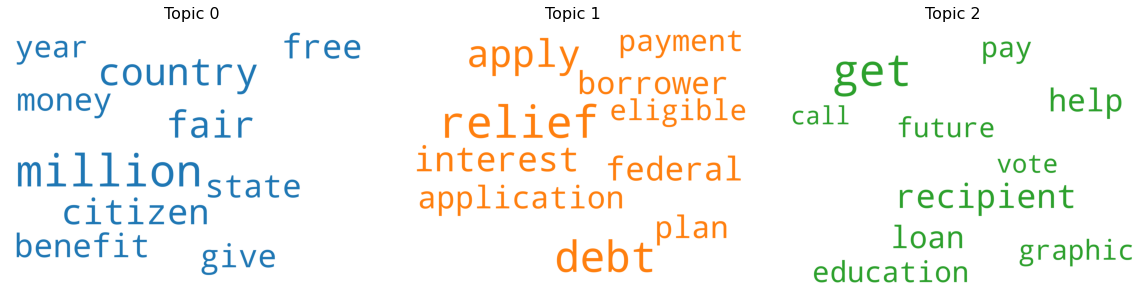

In [359]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(16,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    # give i == Number of topics
    if i==3:
        break
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Word Counts of Topic Keywords


When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the documents is also interesting to look.<br>

Let’s plot the word counts and the weights of each keyword in the same chart.

C:\Users\Arunaggiri Pandian\AppData\Local\Temp\ipykernel_16284\3531178017.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\Users\Arunaggiri Pandian\AppData\Local\Temp\ipykernel_16284\3531178017.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\Users\Arunaggiri Pandian\AppData\Local\Temp\ipykernel_16284\3531178017.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


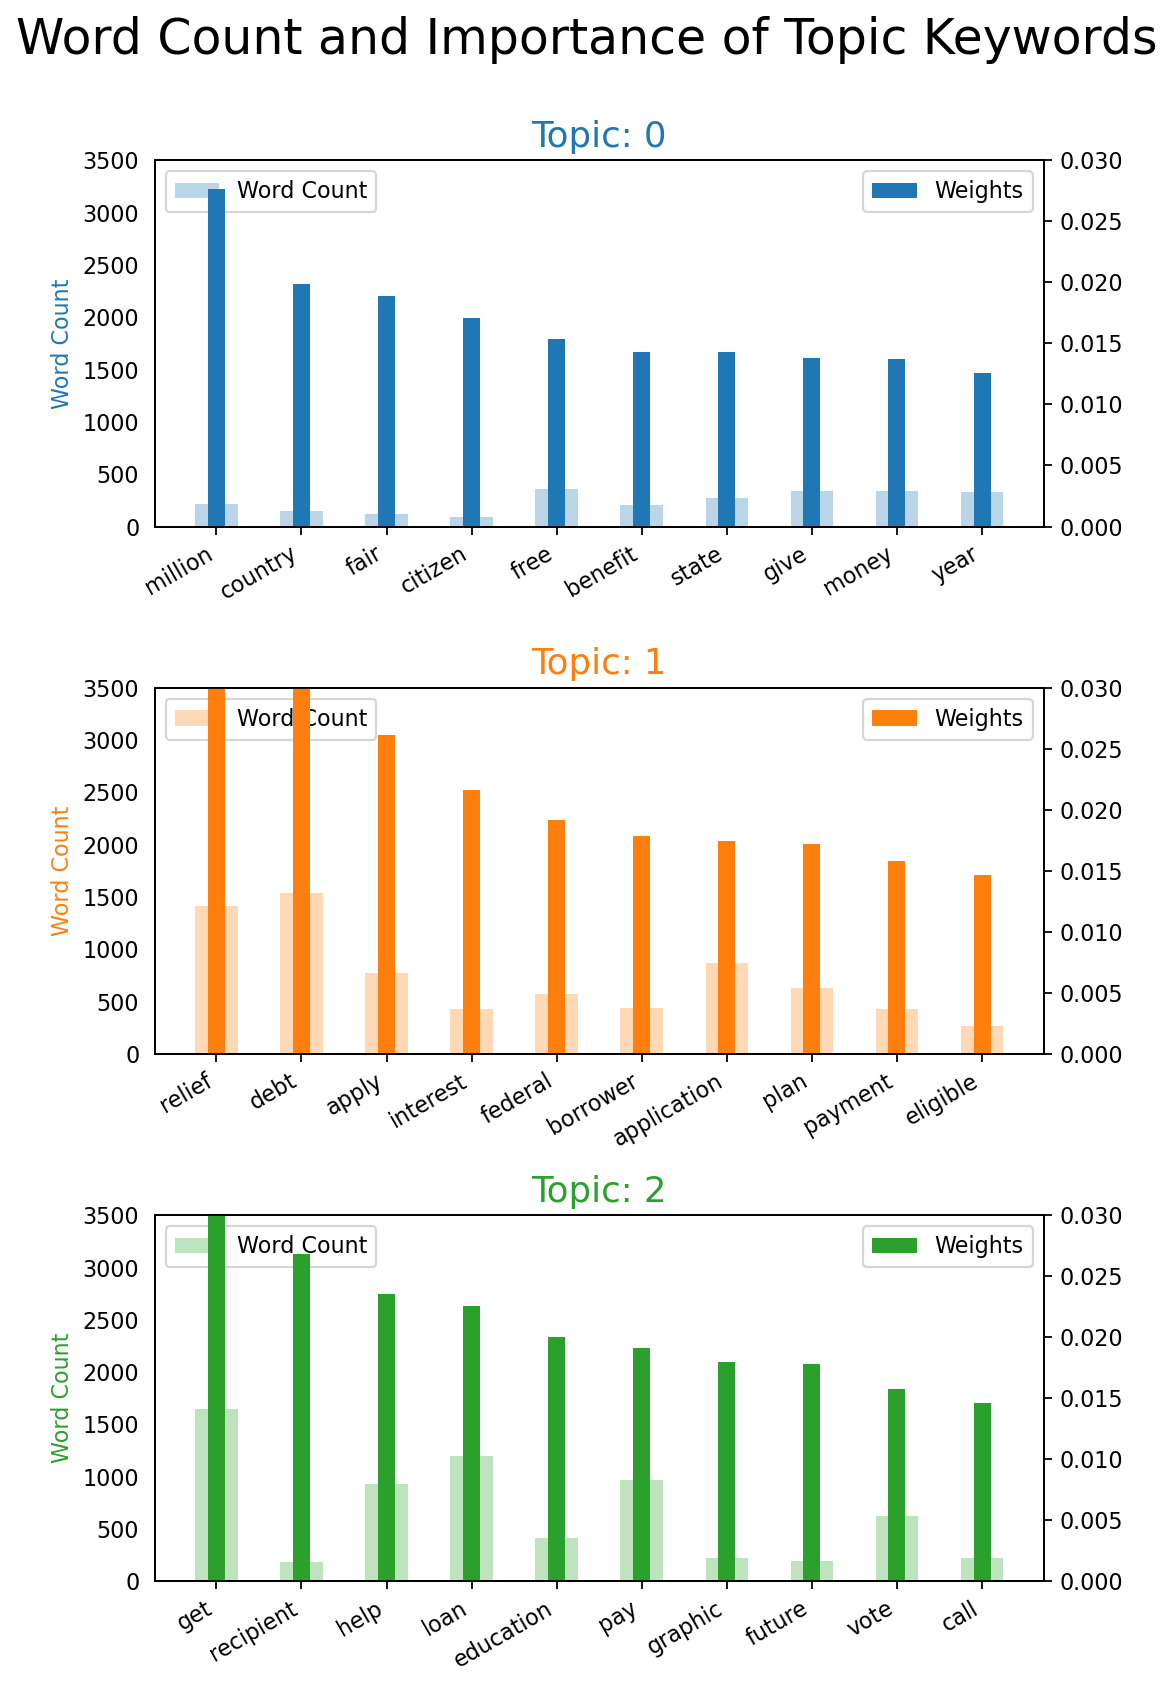

In [360]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 1, figsize=(7,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    if i==3:
        break
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## Sentence Chart Colored by Topic


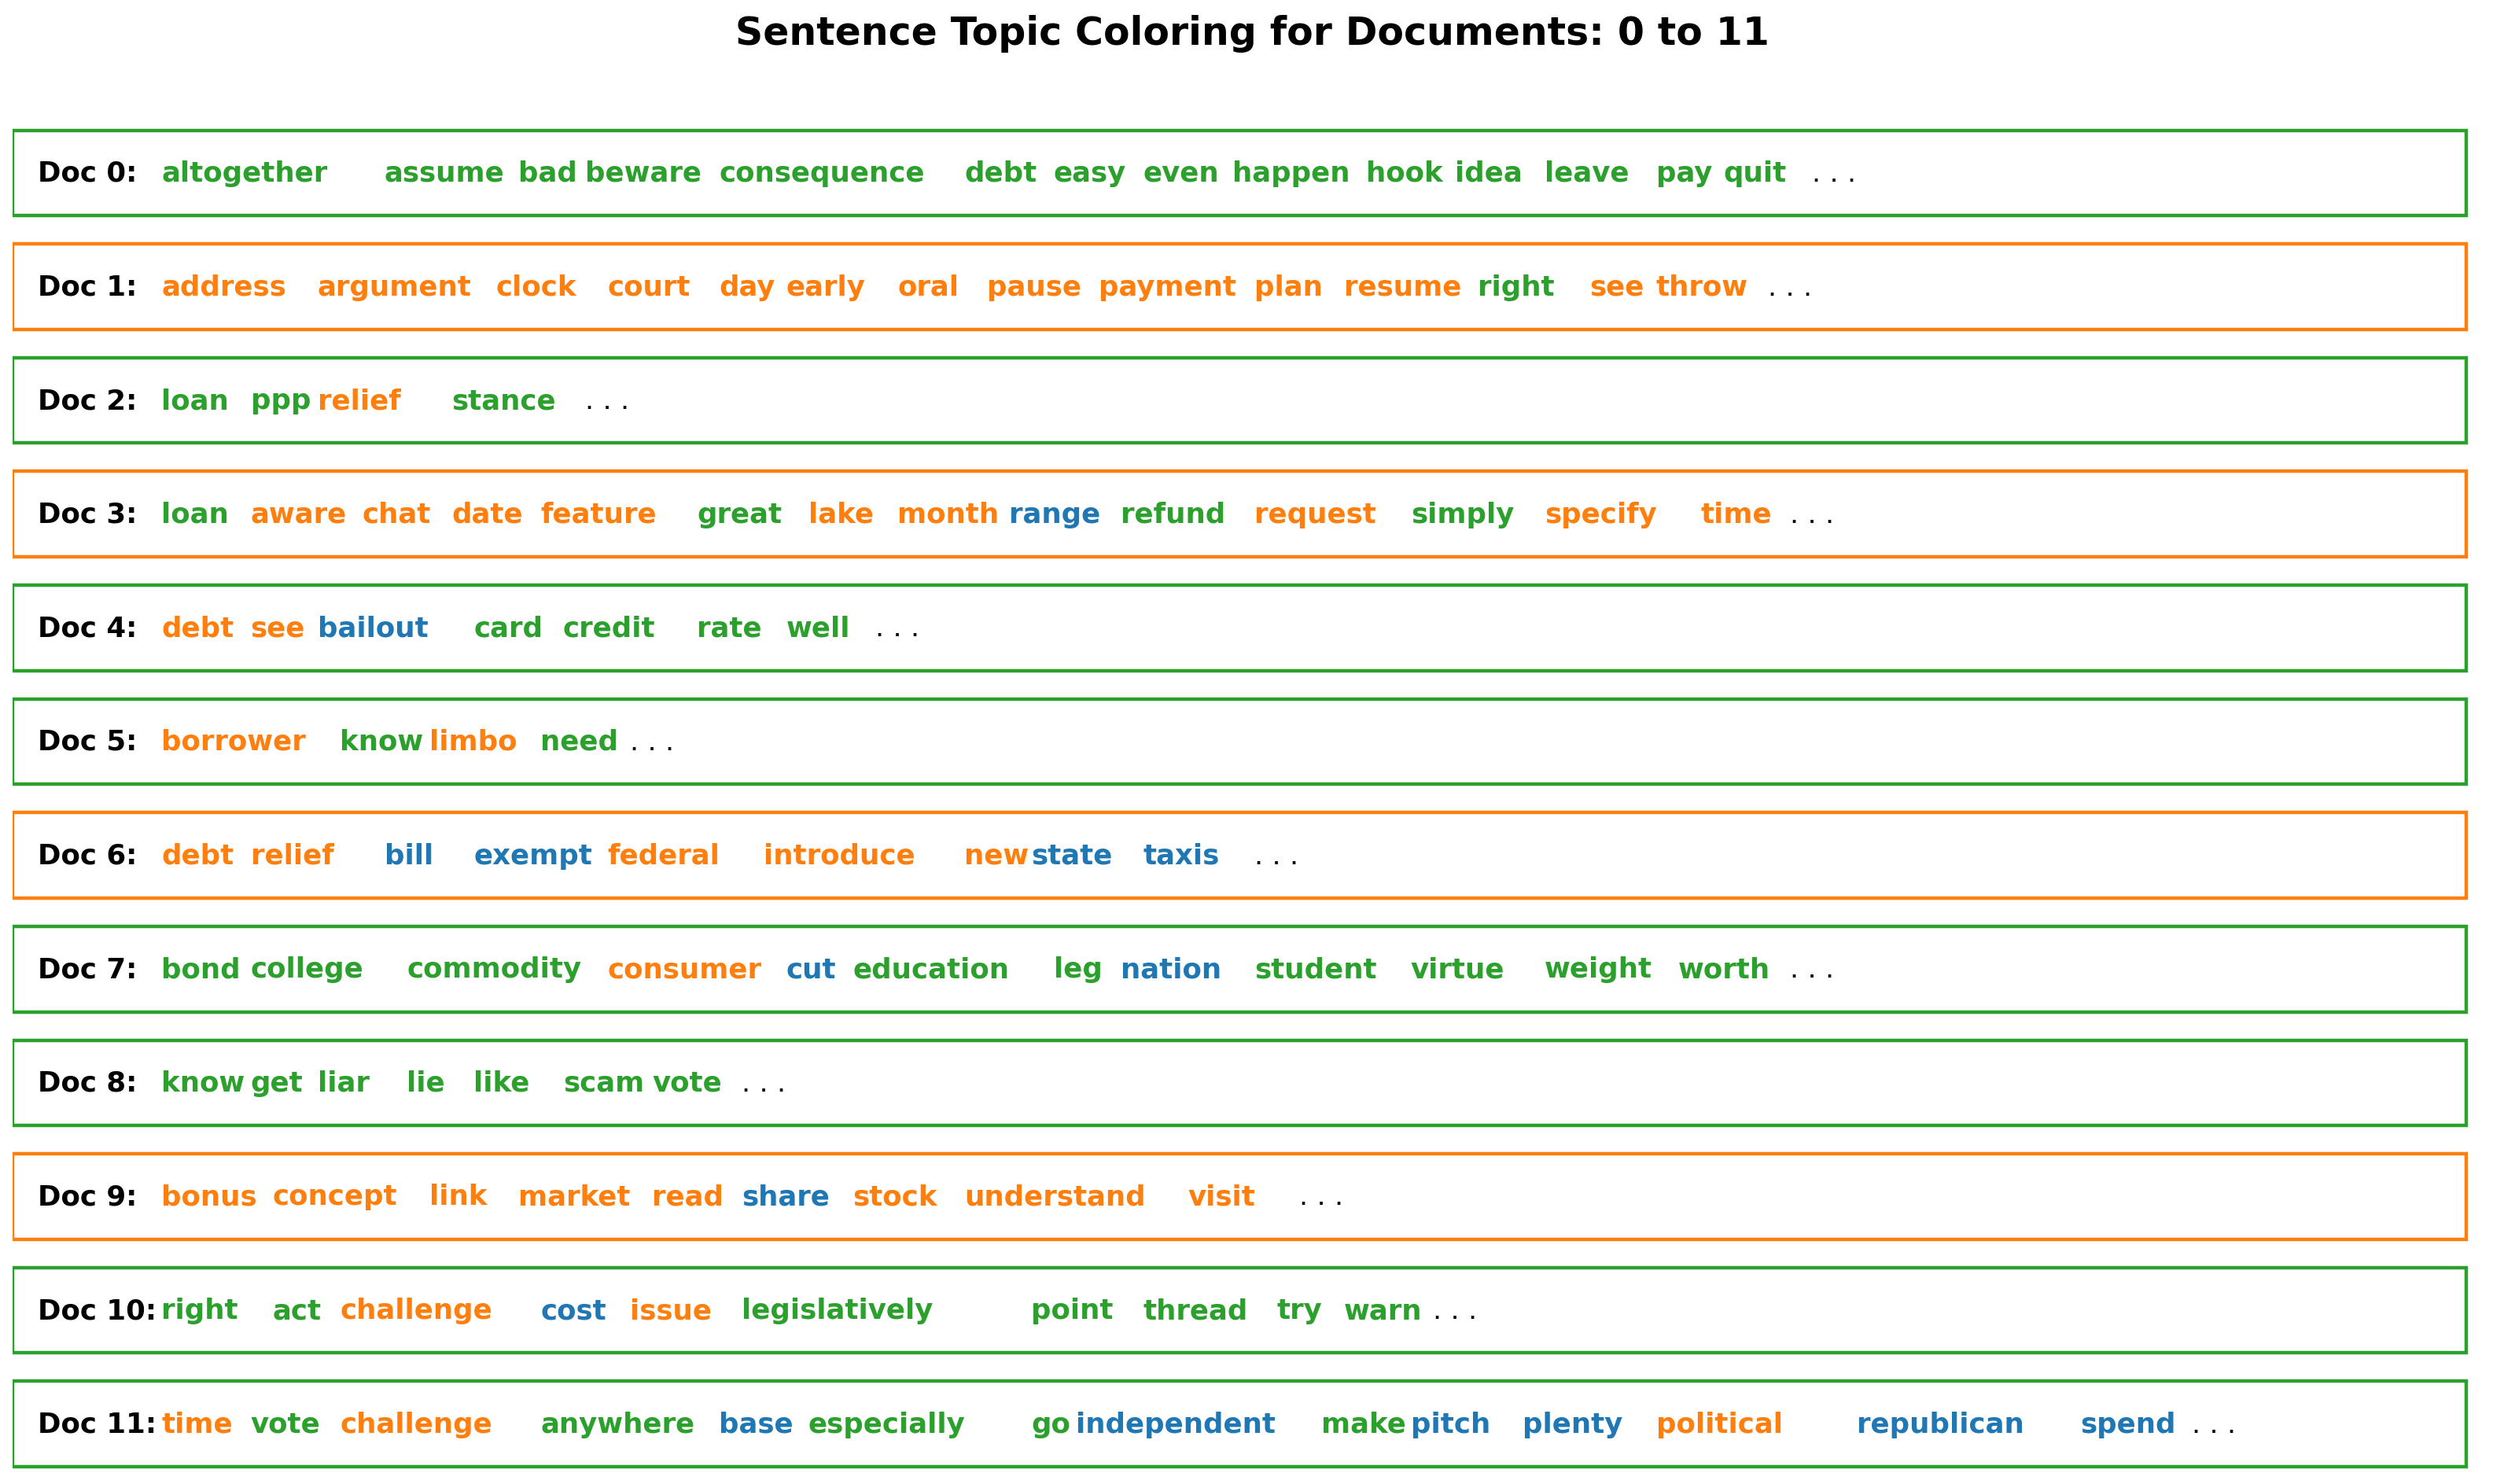

In [361]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

## What are the most discussed topics in the documents?

In [362]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

Let's make 2 plots: <br>

The number of documents for each topic by assigning the document to the topic that has the most weight in that document.<br>
The number of documents for each topic by by summing up the actual weight contribution of each topic to respective documents.<br>

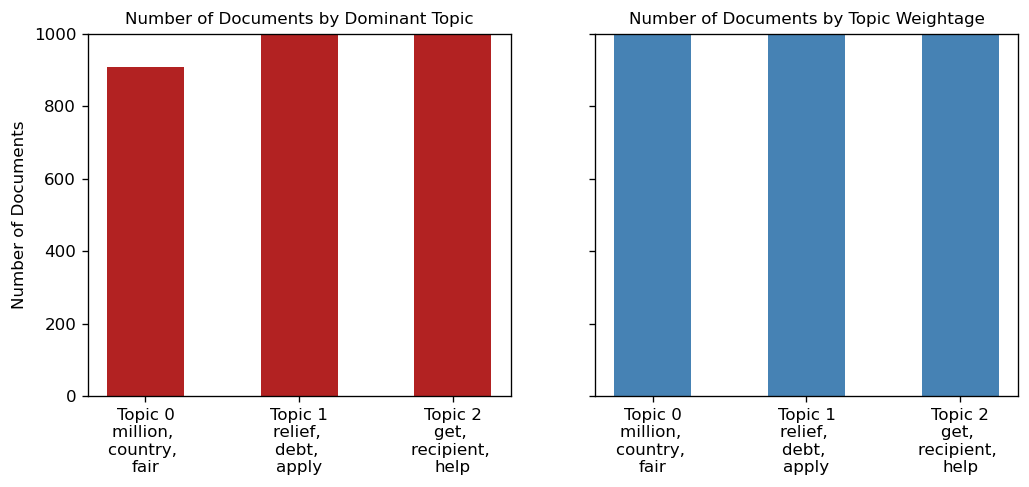

In [363]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

## t-SNE Clustering Chart
Let’s visualize the clusters of documents in a 2D space using t-SNE (t-distributed stochastic neighbor embedding) algorithm.

In [364]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 3
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

C:\Users\Arunaggiri Pandian\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9446 samples in 0.038s...
[t-SNE] Computed neighbors for 9446 samples in 0.130s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9446
[t-SNE] Computed conditional probabilities for sample 2000 / 9446
[t-SNE] Computed conditional probabilities for sample 3000 / 9446
[t-SNE] Computed conditional probabilities for sample 4000 / 9446
[t-SNE] Computed conditional probabilities for sample 5000 / 9446
[t-SNE] Computed conditional probabilities for sample 6000 / 9446
[t-SNE] Computed conditional probabilities for sample 7000 / 9446
[t-SNE] Computed conditional probabilities for sample 8000 / 9446
[t-SNE] Computed conditional probabilities for sample 9000 / 9446
[t-SNE] Computed conditional probabilities for sample 9446 / 9446
[t-SNE] Mean sigma: 0.000000


C:\Users\Arunaggiri Pandian\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.496944
[t-SNE] KL divergence after 1000 iterations: 0.659314


Loading BokehJS ...

## Topic Modeling for Negative Tweets

In [365]:
# Let's load only the tweets labelled as -ve

df = pd.read_csv('negative_tweets.csv')

In [366]:
#stop_words = set(stopwords.words('english'))

# stopwords.add('&AMP')
stop_words.add('re')
stop_words.add('also')
stop_words.add('say')
stop_words.add('go')
stop_words.add('get')
stop_words.add('here')
stop_words.add('still')
stop_words.add('much')

In [367]:
data_words_nostops = remove_stopwords(df.Cleaned_Tweet.str.split())

# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [368]:
print(data_lemmatized[0])

['time', 'wipe', 'debt', 'create', 'entirely', 'new', 'system']


In [369]:
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]]


In [370]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('create', 1),
  ('debt', 1),
  ('entirely', 1),
  ('new', 1),
  ('system', 1),
  ('time', 1),
  ('wipe', 1)]]

In [371]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [372]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

## PPP - Paycheck Protectino Program

[(0,
  '0.024*"borrower" + 0.017*"payment" + 0.015*"crisis" + 0.013*"new" + '
  '0.012*"today" + 0.010*"call" + 0.009*"check" + 0.009*"end" + 0.009*"high" + '
  '0.008*"way"'),
 (1,
  '0.023*"plan" + 0.019*"block" + 0.017*"biden" + 0.017*"relief" + '
  '0.015*"federal" + 0.015*"vote" + 0.014*"know" + 0.013*"stop" + '
  '0.013*"program" + 0.011*"cancellation"'),
 (2,
  '0.083*"debt" + 0.037*"pay" + 0.020*"people" + 0.018*"loan" + '
  '0.017*"college" + 0.016*"make" + 0.016*"take" + 0.014*"time" + '
  '0.010*"cancel" + 0.010*"year"')]


## Topics in Negative Tweets could be labelled as:
### Topic - 0: Borrower
### Topic - 1: Plan
### Topic - 2: Debt

In [373]:
# Visualize the topics
import pyLDAvis.gensim_models as gvis
pyLDAvis.enable_notebook()
vis = gvis.prepare(lda_model, corpus, id2word)
vis

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.249171 -0.163976       1        1  40.818423
1     -0.274698 -0.122149       2        1  38.320075
0      0.025527  0.286126       3        1  20.861502, topic_info=           Term         Freq        Total Category  logprob  loglift
1          debt  2122.000000  2122.000000  Default  30.0000  30.0000
201         pay   883.000000   883.000000  Default  29.0000  29.0000
258        plan   514.000000   514.000000  Default  28.0000  28.0000
7      borrower   294.000000   294.000000  Default  27.0000  27.0000
207      people   481.000000   481.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1797   announce    66.215247    67.519650   Topic3  -5.2092   1.5478
1685    default    55.390482    56.606647   Topic3  -5.3877   1.5455
830    american    80.479788    85.182018   Topic3  -5.0141   1.5105
611   financial    80.265764    86.520370   Topic3  -5.0168   1.4922
236     student    84.587722   288.483620   Topic3  -4.9643   0.3404

[141 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
830       1  0.046958  american
830       3  0.939165  american
1797      1  0.014811  announce
1797      2  0.014811  announce
1797      3  0.977493  announce
...     ...       ...       ...
60        3  0.991429     watch
113       3  0.995710       way
853       1  0.990207      well
377       1  0.996247      work
605       1  0.995194      year

[130 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [374]:
# Compute Perplexity

print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.553735984439666

Coherence Score:  0.27439052147797527


## What is the Dominant topic and its percentage contribution in each document


In [375]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data_lemmatized):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

C:\Users\Arunaggiri Pandian\AppData\Local\Temp\ipykernel_16284\3081464463.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\Arunaggiri Pandian\AppData\Local\Temp\ipykernel_16284\3081464463.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2,0.4215,"debt, pay, people, loan, college, make, take, time, cancel, year","[time, wipe, debt, create, entirely, new, system]"
1,1,0,0.4402,"borrower, payment, crisis, new, today, call, check, end, high, way","[illegal, constitutional, government, contract, federal, borrower, loan, likely, deem, illegal, ..."
2,2,1,0.7811,"plan, block, biden, relief, federal, vote, know, stop, program, cancellation","[feel, know, go, pass, face, headwind, process, election, come, try, show, do, block, hopefull, ..."
3,3,2,0.4852,"debt, pay, people, loan, college, make, take, time, cancel, year","[wait, damn, minute, send, billion, dollar, ukraine, fuggin, money, back, dammit]"
4,4,2,0.5381,"debt, pay, people, loan, college, make, take, time, cancel, year","[trump, say, portion, need, change, simply, ignore, constitution, altogether]"
5,5,1,0.7010,"plan, block, biden, relief, federal, vote, know, stop, program, cancellation","[lie, vote, know, scam, vote, republican, truth, future]"
6,6,1,0.4196,"plan, block, biden, relief, federal, vote, know, stop, program, cancellation","[watch, administration, try, back, peddle]"
7,7,1,0.7245,"plan, block, biden, relief, federal, vote, know, stop, program, cancellation","[finally, dumb, move, do, challenge, court, immediately, use, party, rightfully]"
8,8,0,0.5186,"borrower, payment, crisis, new, today, call, check, end, high, way","[behoove, recruit, voter, problem, bail, bank, corporation, taxpayer, dollar, hide, look, elitis..."
9,9,1,0.4273,"plan, block, biden, relief, federal, vote, know, stop, program, cancellation","[currently, debt, forgive, advocate, assume, pass, muster, failure, specifically, due, put, part..."


## The most representative sentence for each topic

In [376]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.6862,"borrower, payment, crisis, new, today, call, check, end, high, way","[increase, payment, exist, borrower, push, set, benefit, selective, portion, borrower, leave, ff..."
1,1,0.8104,"plan, block, biden, relief, federal, vote, know, stop, program, cancellation","[cancelation, plan, block, court, unexpected, move, court, appeal, eighth, circuit, issue, tempo..."
2,2,0.7992,"debt, pay, people, loan, college, make, take, time, cancel, year","[sure, opportunistic, bastard, want, beat, haitian, border, take, loan, forgive, castigate, poor..."


## Word Clouds of Top 10 Keywords in Each Topic

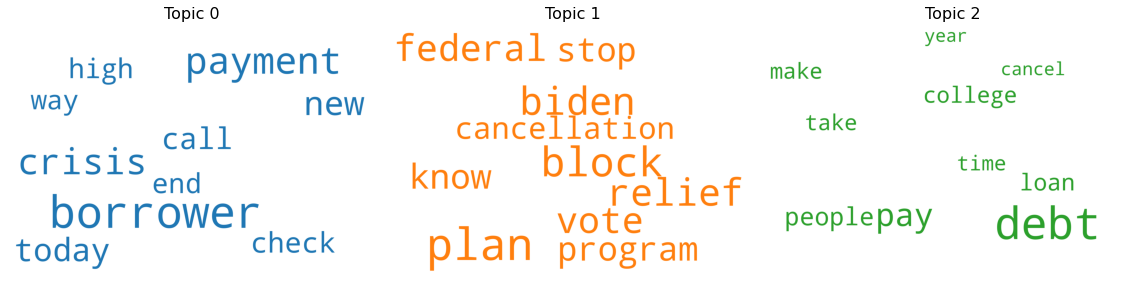

In [377]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(16,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    # give i == Number of topics
    if i==3:
        break
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Word Counts of Topic Keywords

When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the documents is also interesting to look.<br>

Let’s plot the word counts and the weights of each keyword in the same chart.

C:\Users\Arunaggiri Pandian\AppData\Local\Temp\ipykernel_16284\3531178017.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\Users\Arunaggiri Pandian\AppData\Local\Temp\ipykernel_16284\3531178017.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\Users\Arunaggiri Pandian\AppData\Local\Temp\ipykernel_16284\3531178017.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


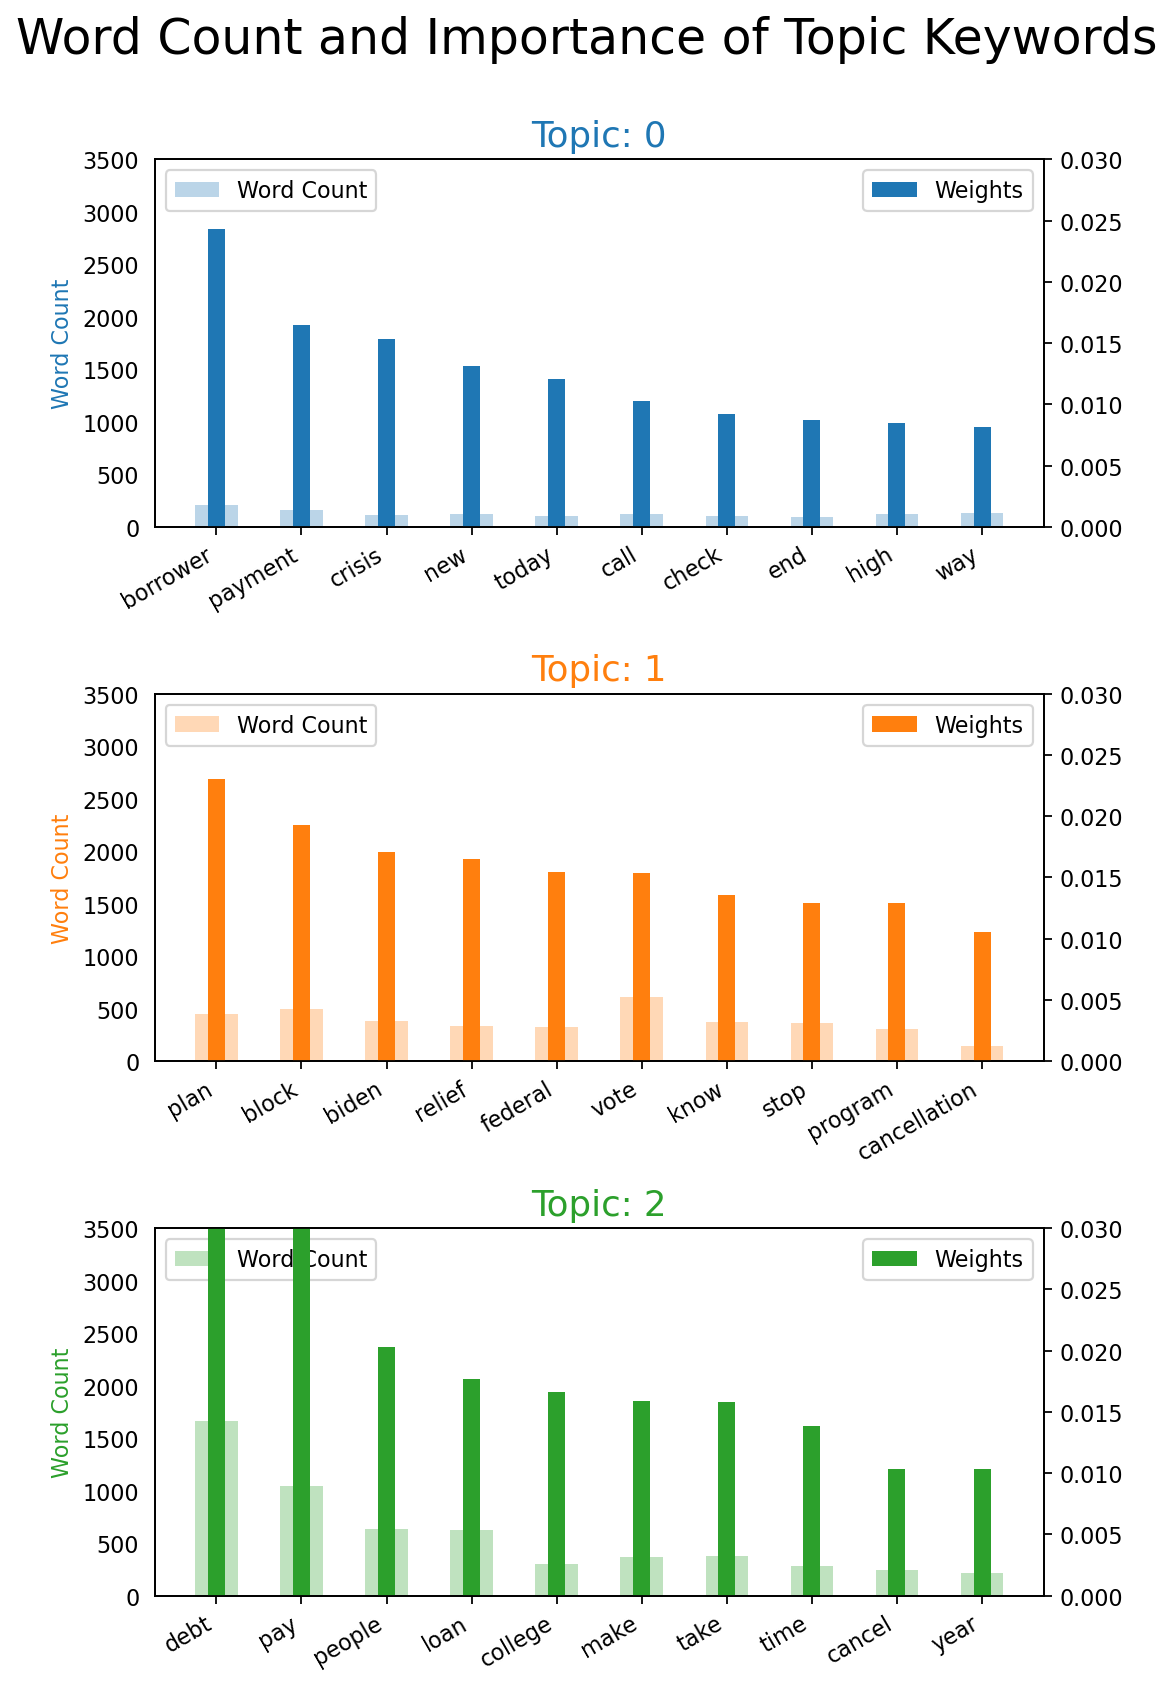

In [378]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 1, figsize=(7,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    if i==3:
        break
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## Sentence Chart Colored by Topic

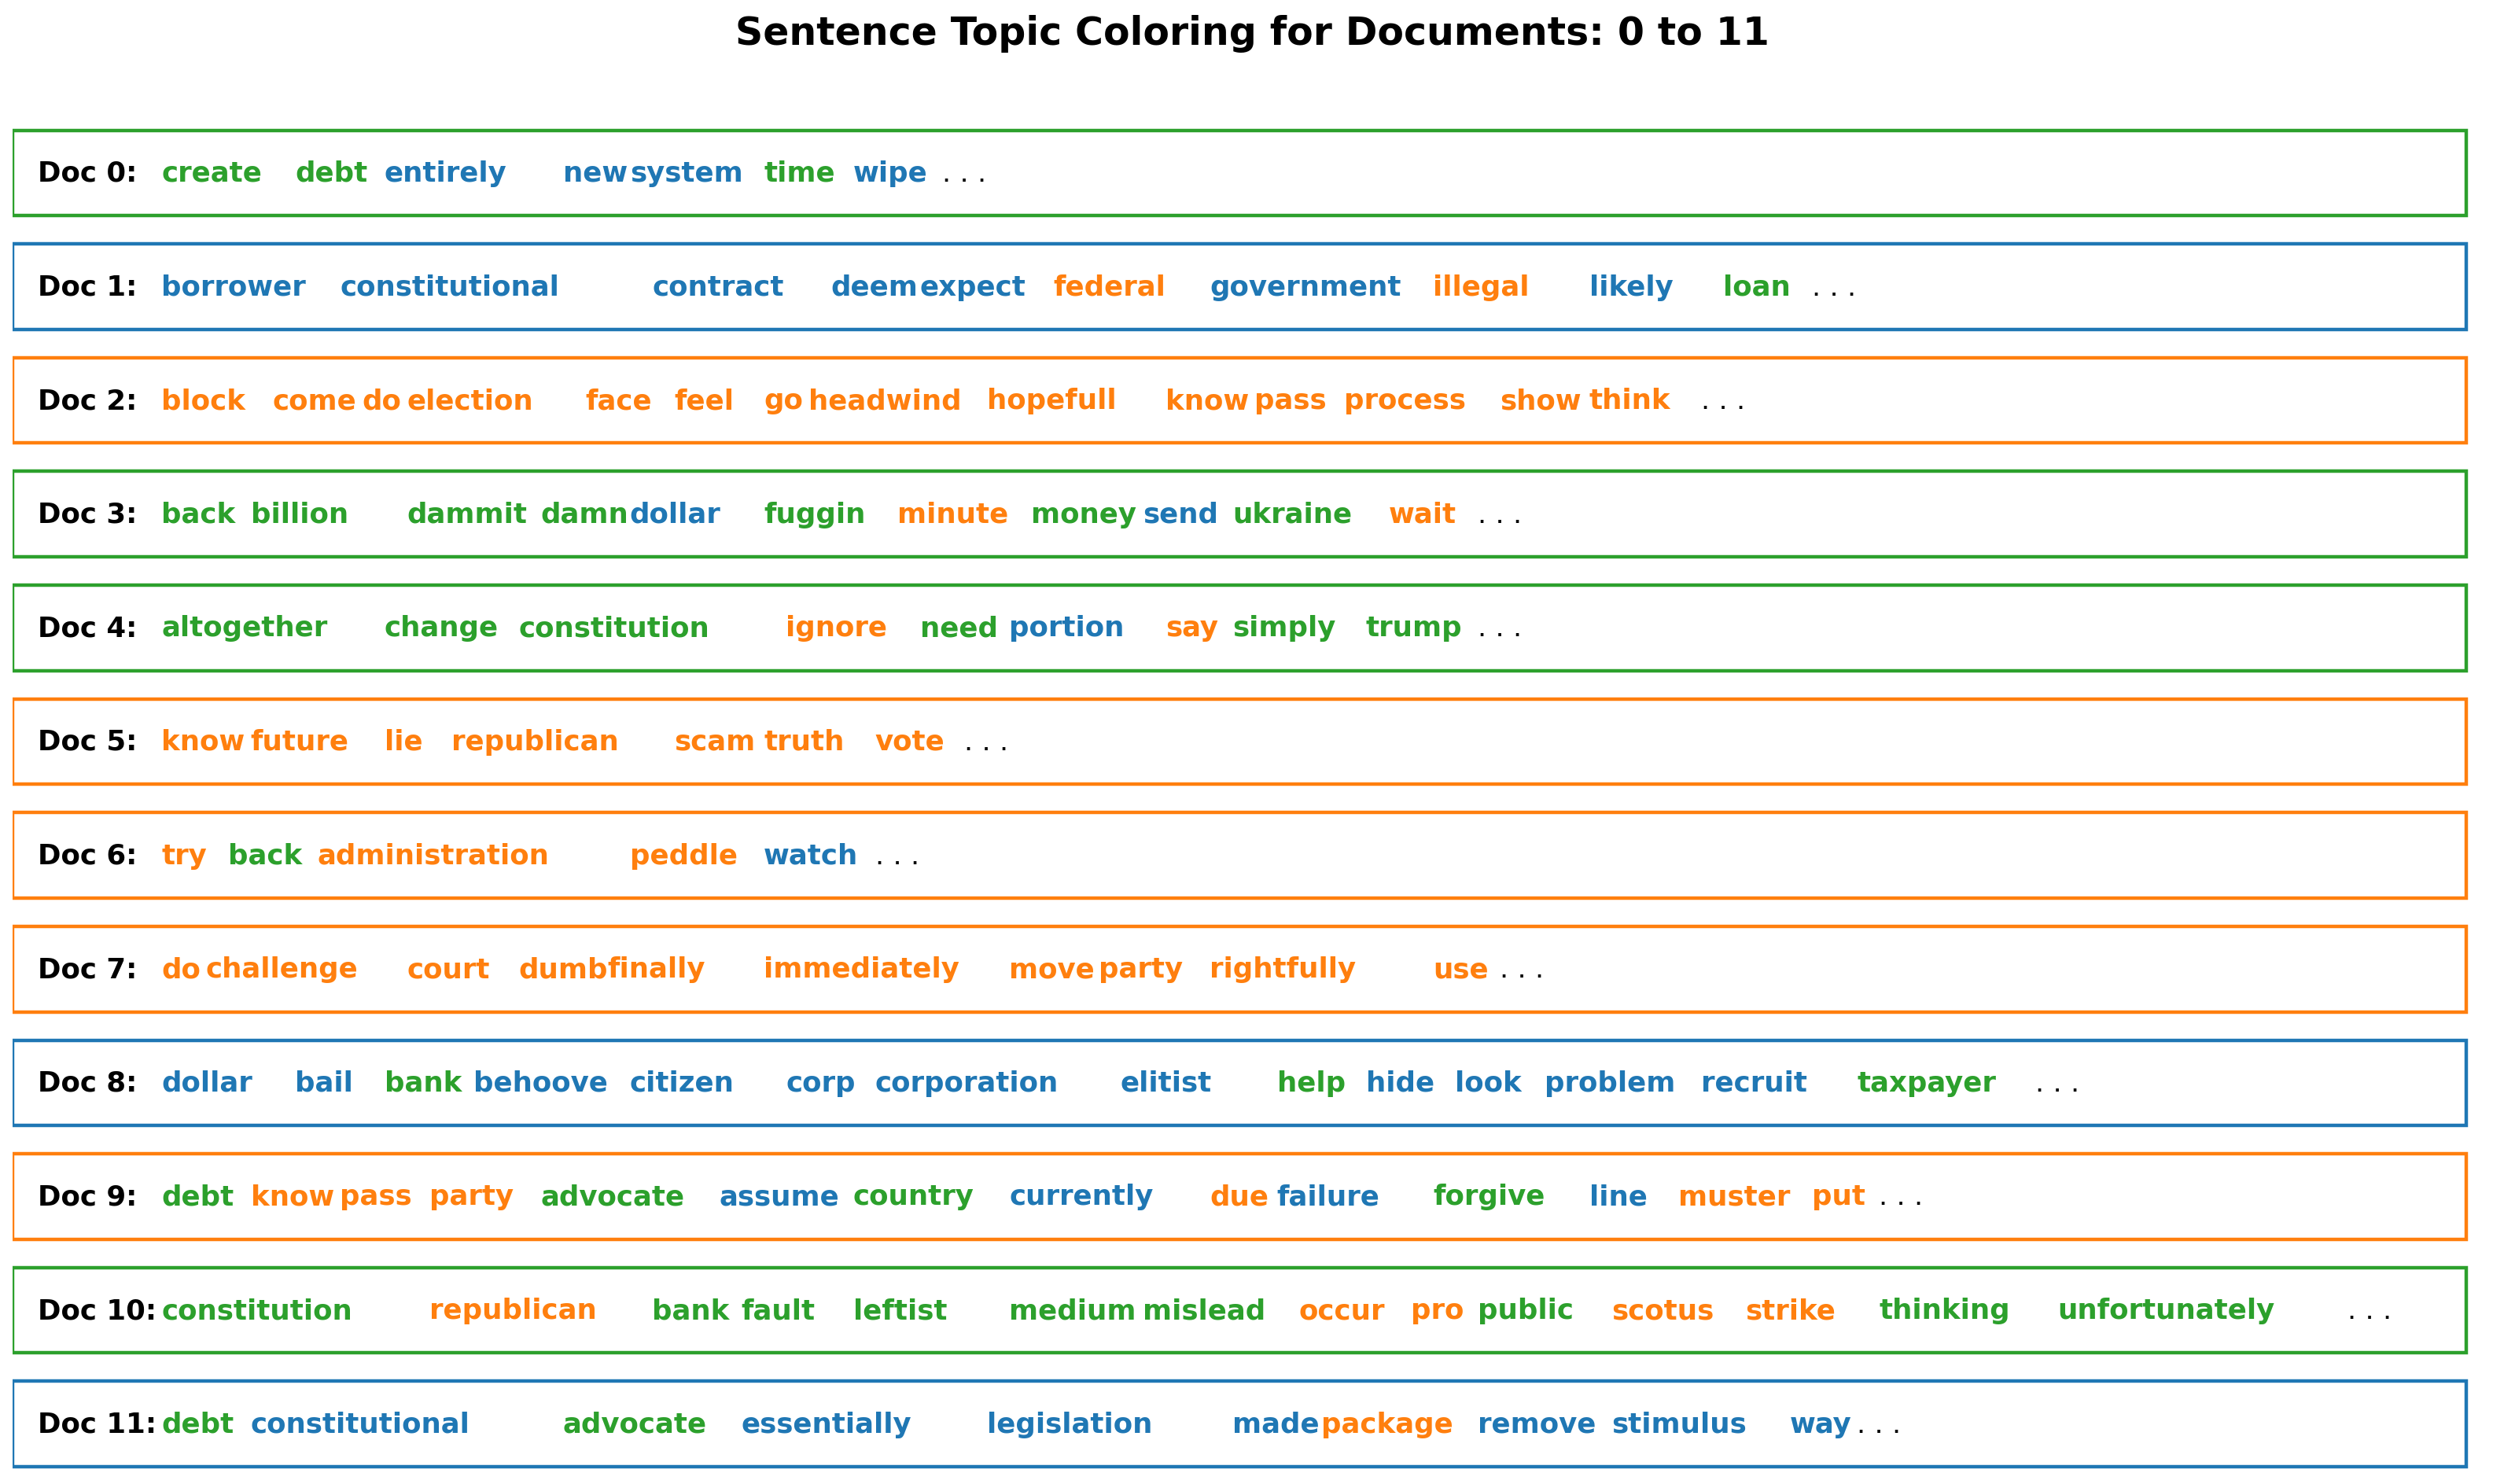

In [379]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

## What are the most discussed topics in the documents?

In [380]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

Let's make 2 plots: <br>

The number of documents for each topic by assigning the document to the topic that has the most weight in that document.<br>
The number of documents for each topic by by summing up the actual weight contribution of each topic to respective documents.<br>

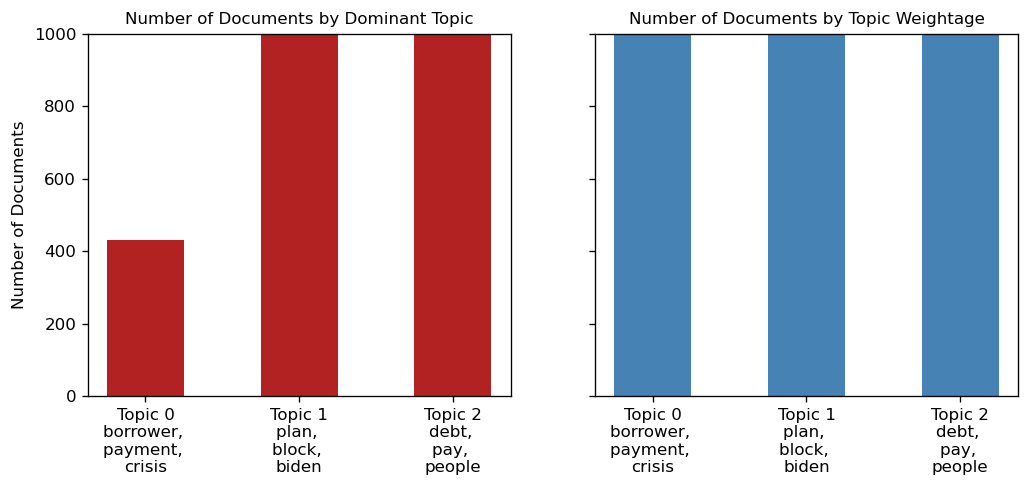

In [381]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

## t-SNE Clustering Chart
Let’s visualize the clusters of documents in a 2D space using t-SNE (t-distributed stochastic neighbor embedding) algorithm.

In [382]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 3
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

C:\Users\Arunaggiri Pandian\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5728 samples in 0.005s...
[t-SNE] Computed neighbors for 5728 samples in 0.076s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5728
[t-SNE] Computed conditional probabilities for sample 2000 / 5728
[t-SNE] Computed conditional probabilities for sample 3000 / 5728
[t-SNE] Computed conditional probabilities for sample 4000 / 5728


C:\Users\Arunaggiri Pandian\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computed conditional probabilities for sample 5000 / 5728
[t-SNE] Computed conditional probabilities for sample 5728 / 5728
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.332577
[t-SNE] KL divergence after 1000 iterations: 0.606915


Loading BokehJS ...

## Topic Modeling for Neutral Tweets

In [383]:
# Let's load only the tweets labelled as neutral

df = pd.read_csv('neutral_tweets.csv')

In [384]:
# #stop_words = set(stopwords.words('english'))

stop_words.add('yes')
stop_words.add('re')
stop_words.add('put')
stop_words.add('s')
stop_words.add('go')
stop_words.add('let')
stop_words.add('yeat')
stop_words.add('see')
stop_words.add('come')

In [385]:
data_words_nostops = remove_stopwords(df.Cleaned_Tweet.str.split())

# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [386]:
print(data_lemmatized[0])

['right', 'thing', 'million', 'american']


In [387]:
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


In [388]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('american', 1), ('million', 1), ('right', 1), ('thing', 1)]]

In [389]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [390]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.029*"know" + 0.027*"people" + 0.021*"take" + 0.021*"pay" + 0.020*"need" + '
  '0.020*"debt" + 0.015*"learn" + 0.013*"school" + 0.012*"new" + '
  '0.012*"check"'),
 (1,
  '0.048*"apply" + 0.027*"application" + 0.021*"visit" + 0.016*"program" + '
  '0.015*"today" + 0.014*"get" + 0.014*"website" + 0.012*"receive" + '
  '0.012*"access" + 0.011*"open"'),
 (2,
  '0.027*"loan" + 0.026*"plan" + 0.024*"education" + 0.018*"repayment" + '
  '0.016*"payment" + 0.016*"make" + 0.014*"borrower" + 0.012*"college" + '
  '0.012*"high" + 0.012*"re"')]


## Topics in Neutral Tweets could be labelled as:
### Topic - 0: People
### Topic - 1: Application
### Topic - 2: Education

In [391]:
# Visualize the topics
import pyLDAvis.gensim_models as gvis
pyLDAvis.enable_notebook()
vis = gvis.prepare(lda_model, corpus, id2word)
vis

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.269232  0.004064       1        1  36.555826
0      0.130858 -0.220385       2        1  34.645392
1      0.138374  0.216322       3        1  28.798781, topic_info=                 Term        Freq       Total Category  logprob  loglift
58              apply  241.000000  241.000000  Default  30.0000  30.0000
5                know  175.000000  175.000000  Default  29.0000  29.0000
537       application  136.000000  136.000000  Default  28.0000  28.0000
11               loan  169.000000  169.000000  Default  27.0000  27.0000
64             people  161.000000  161.000000  Default  26.0000  26.0000
...               ...         ...         ...      ...      ...      ...
928              part   29.575262   30.335907   Topic3  -5.1278   1.2194
326            relief   29.654723   30.453610   Topic3  -5.1251   1.2183
123          decision   29.859137   30.876796   Topic3  -5.1182   1.2113
3207  democratization   41.492694   51.259748   Topic3  -4.7892   1.0334
3208      executiveed   41.492694   51.259748   Topic3  -4.7892   1.0334

[134 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2216      1  0.016967    access
2216      3  0.984089    access
83        1  0.993941    affect
119       1  0.984099  announce
57        3  0.975936    answer
...     ...       ...       ...
156       2  0.990188       way
1133      3  0.986448   website
390       2  0.977577      week
136       2  0.991523      work
240       1  0.984354      year

[121 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

In [392]:
# Compute Perplexity

print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.7145756334694475

Coherence Score:  0.3532174923778572


## What is the Dominant topic and its percentage contribution in each document

In [393]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data_lemmatized):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

C:\Users\Arunaggiri Pandian\AppData\Local\Temp\ipykernel_16284\3081464463.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\Arunaggiri Pandian\AppData\Local\Temp\ipykernel_16284\3081464463.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2,0.6291,"loan, plan, education, repayment, payment, make, borrower, college, high, re","[right, thing, million, american]"
1,1,2,0.4694,"loan, plan, education, repayment, payment, make, borrower, college, high, re","[know, exactly, offer]"
2,2,0,0.5259,"know, people, take, pay, need, debt, learn, school, new, check","[conservative, uneducated, even, need, loan, bail, government]"
3,3,2,0.5254,"loan, plan, education, repayment, payment, make, borrower, college, high, re","[heart, draw, student]"
4,4,2,0.6291,"loan, plan, education, repayment, payment, make, borrower, college, high, re","[right, thing, million, american]"
5,5,2,0.6601,"loan, plan, education, repayment, payment, make, borrower, college, high, re","[republican, block, pay, time, rail, worker, block, additional, health, care, veteran, good, org..."
6,6,1,0.6901,"apply, application, visit, program, today, get, website, receive, access, open","[lie, entire, adult, life, ever, rest, promise, codify]"
7,7,1,0.6601,"apply, application, visit, program, today, get, website, receive, access, open","[break, full, transcript, social, medium, collusion, case]"
8,8,0,0.4393,"know, people, take, pay, need, debt, learn, school, new, check",[word]
9,9,1,0.5068,"apply, application, visit, program, today, get, website, receive, access, open","[snoop, dogg, official, video]"


## The most representative sentence for each topic

In [394]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.7840,"know, people, take, pay, need, debt, learn, school, new, check","[mind, waitress, plumber, go, pay, rebuild, rich, retiree, beach, house, even, though, buy, home..."
1,1,0.7465,"apply, application, visit, program, today, get, website, receive, access, open","[application, live, beta, testing, submit, application, process, form, officially, launch]"
2,2,0.7847,"loan, plan, education, repayment, payment, make, borrower, college, high, re","[root, purpose, podcast, join, episode, meet, podcast, come, fruition, purpose, root, purpose]"


## Word Clouds of Top 10 Keywords in Each Topic

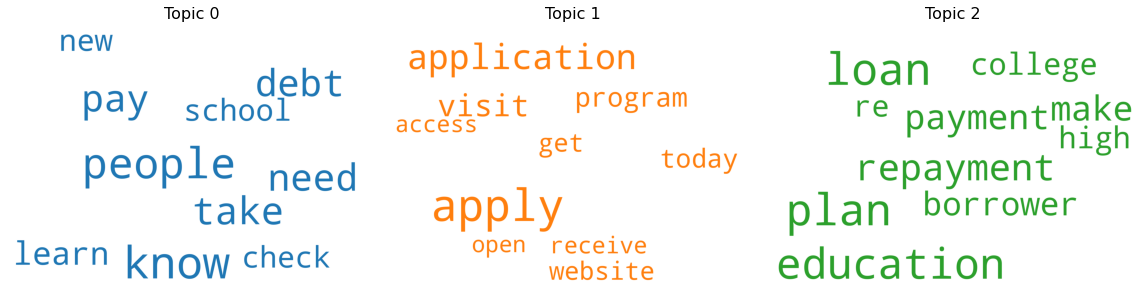

In [397]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(16,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    # give i == Number of topics
    if i==3:
        break
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Word Counts of Topic Keywords

When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the documents is also interesting to look.<br>

Let’s plot the word counts and the weights of each keyword in the same chart.

C:\Users\Arunaggiri Pandian\AppData\Local\Temp\ipykernel_16284\3531178017.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\Users\Arunaggiri Pandian\AppData\Local\Temp\ipykernel_16284\3531178017.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\Users\Arunaggiri Pandian\AppData\Local\Temp\ipykernel_16284\3531178017.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


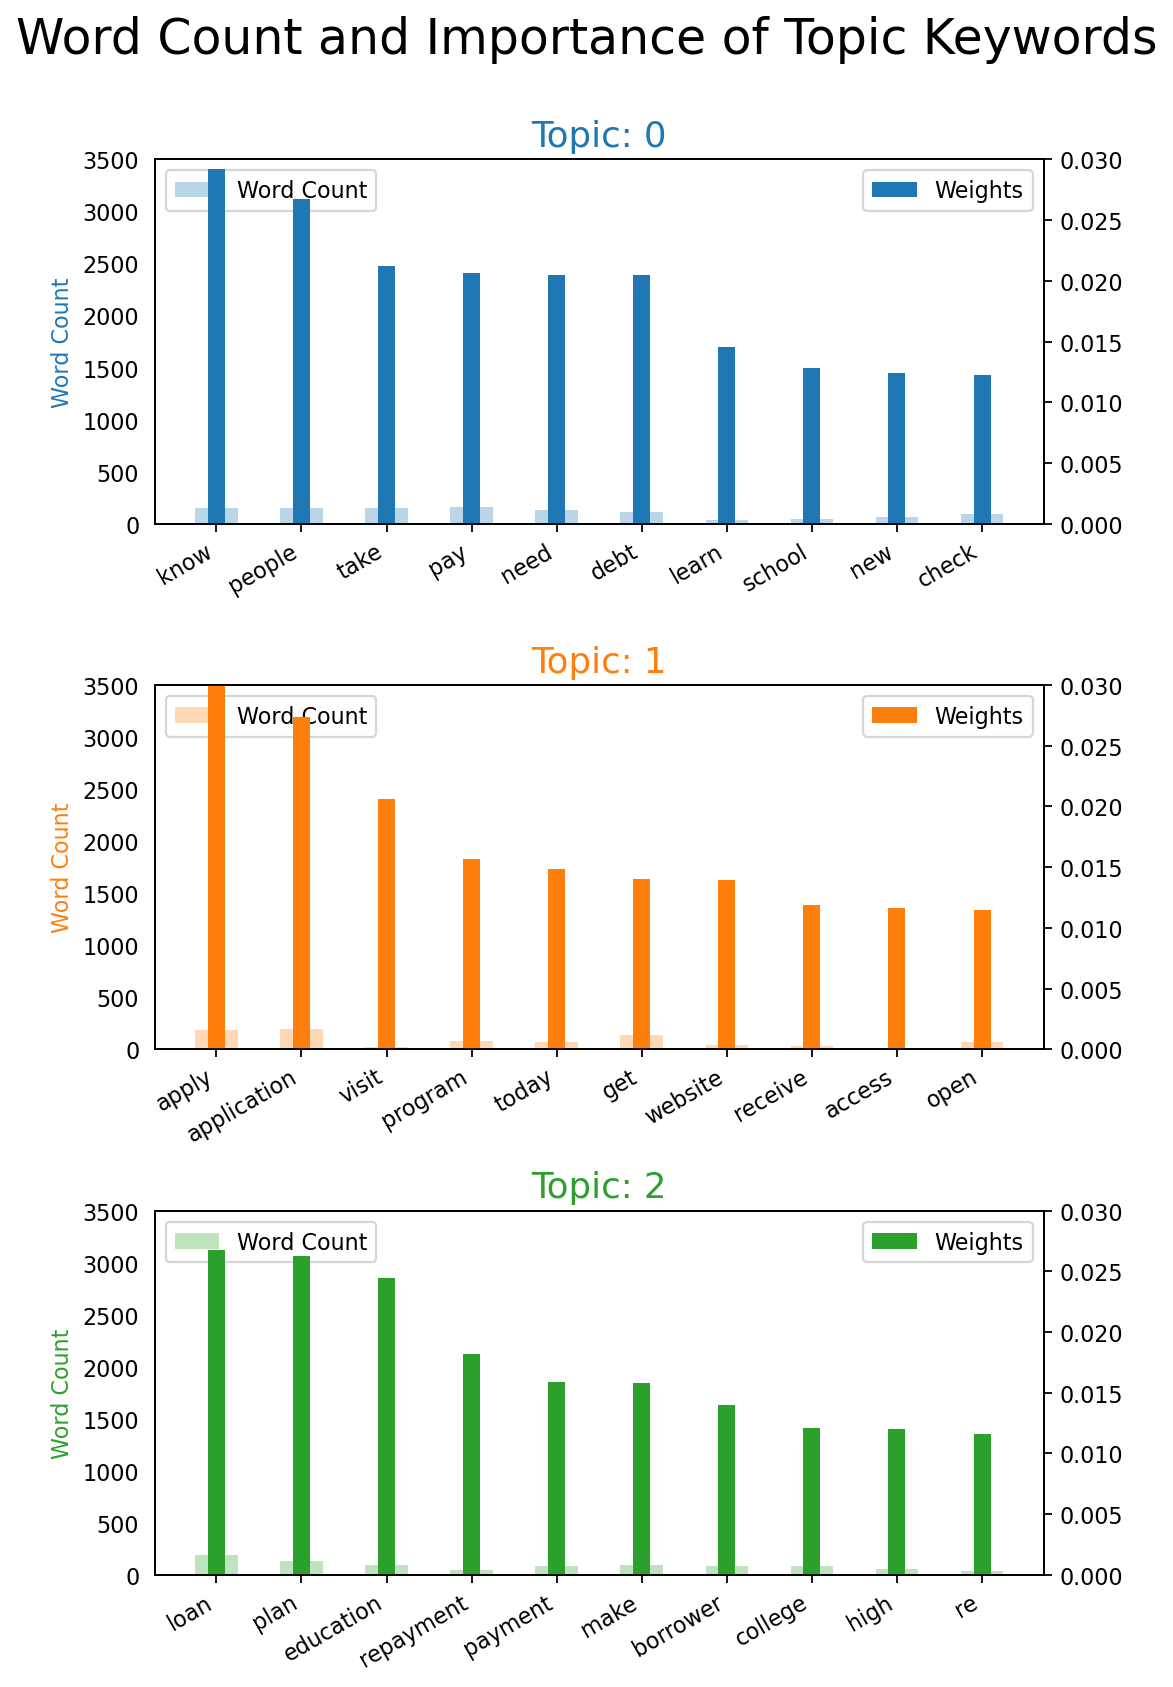

In [398]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 1, figsize=(7,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    if i==3:
        break
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## Sentence Chart Colored by Topic

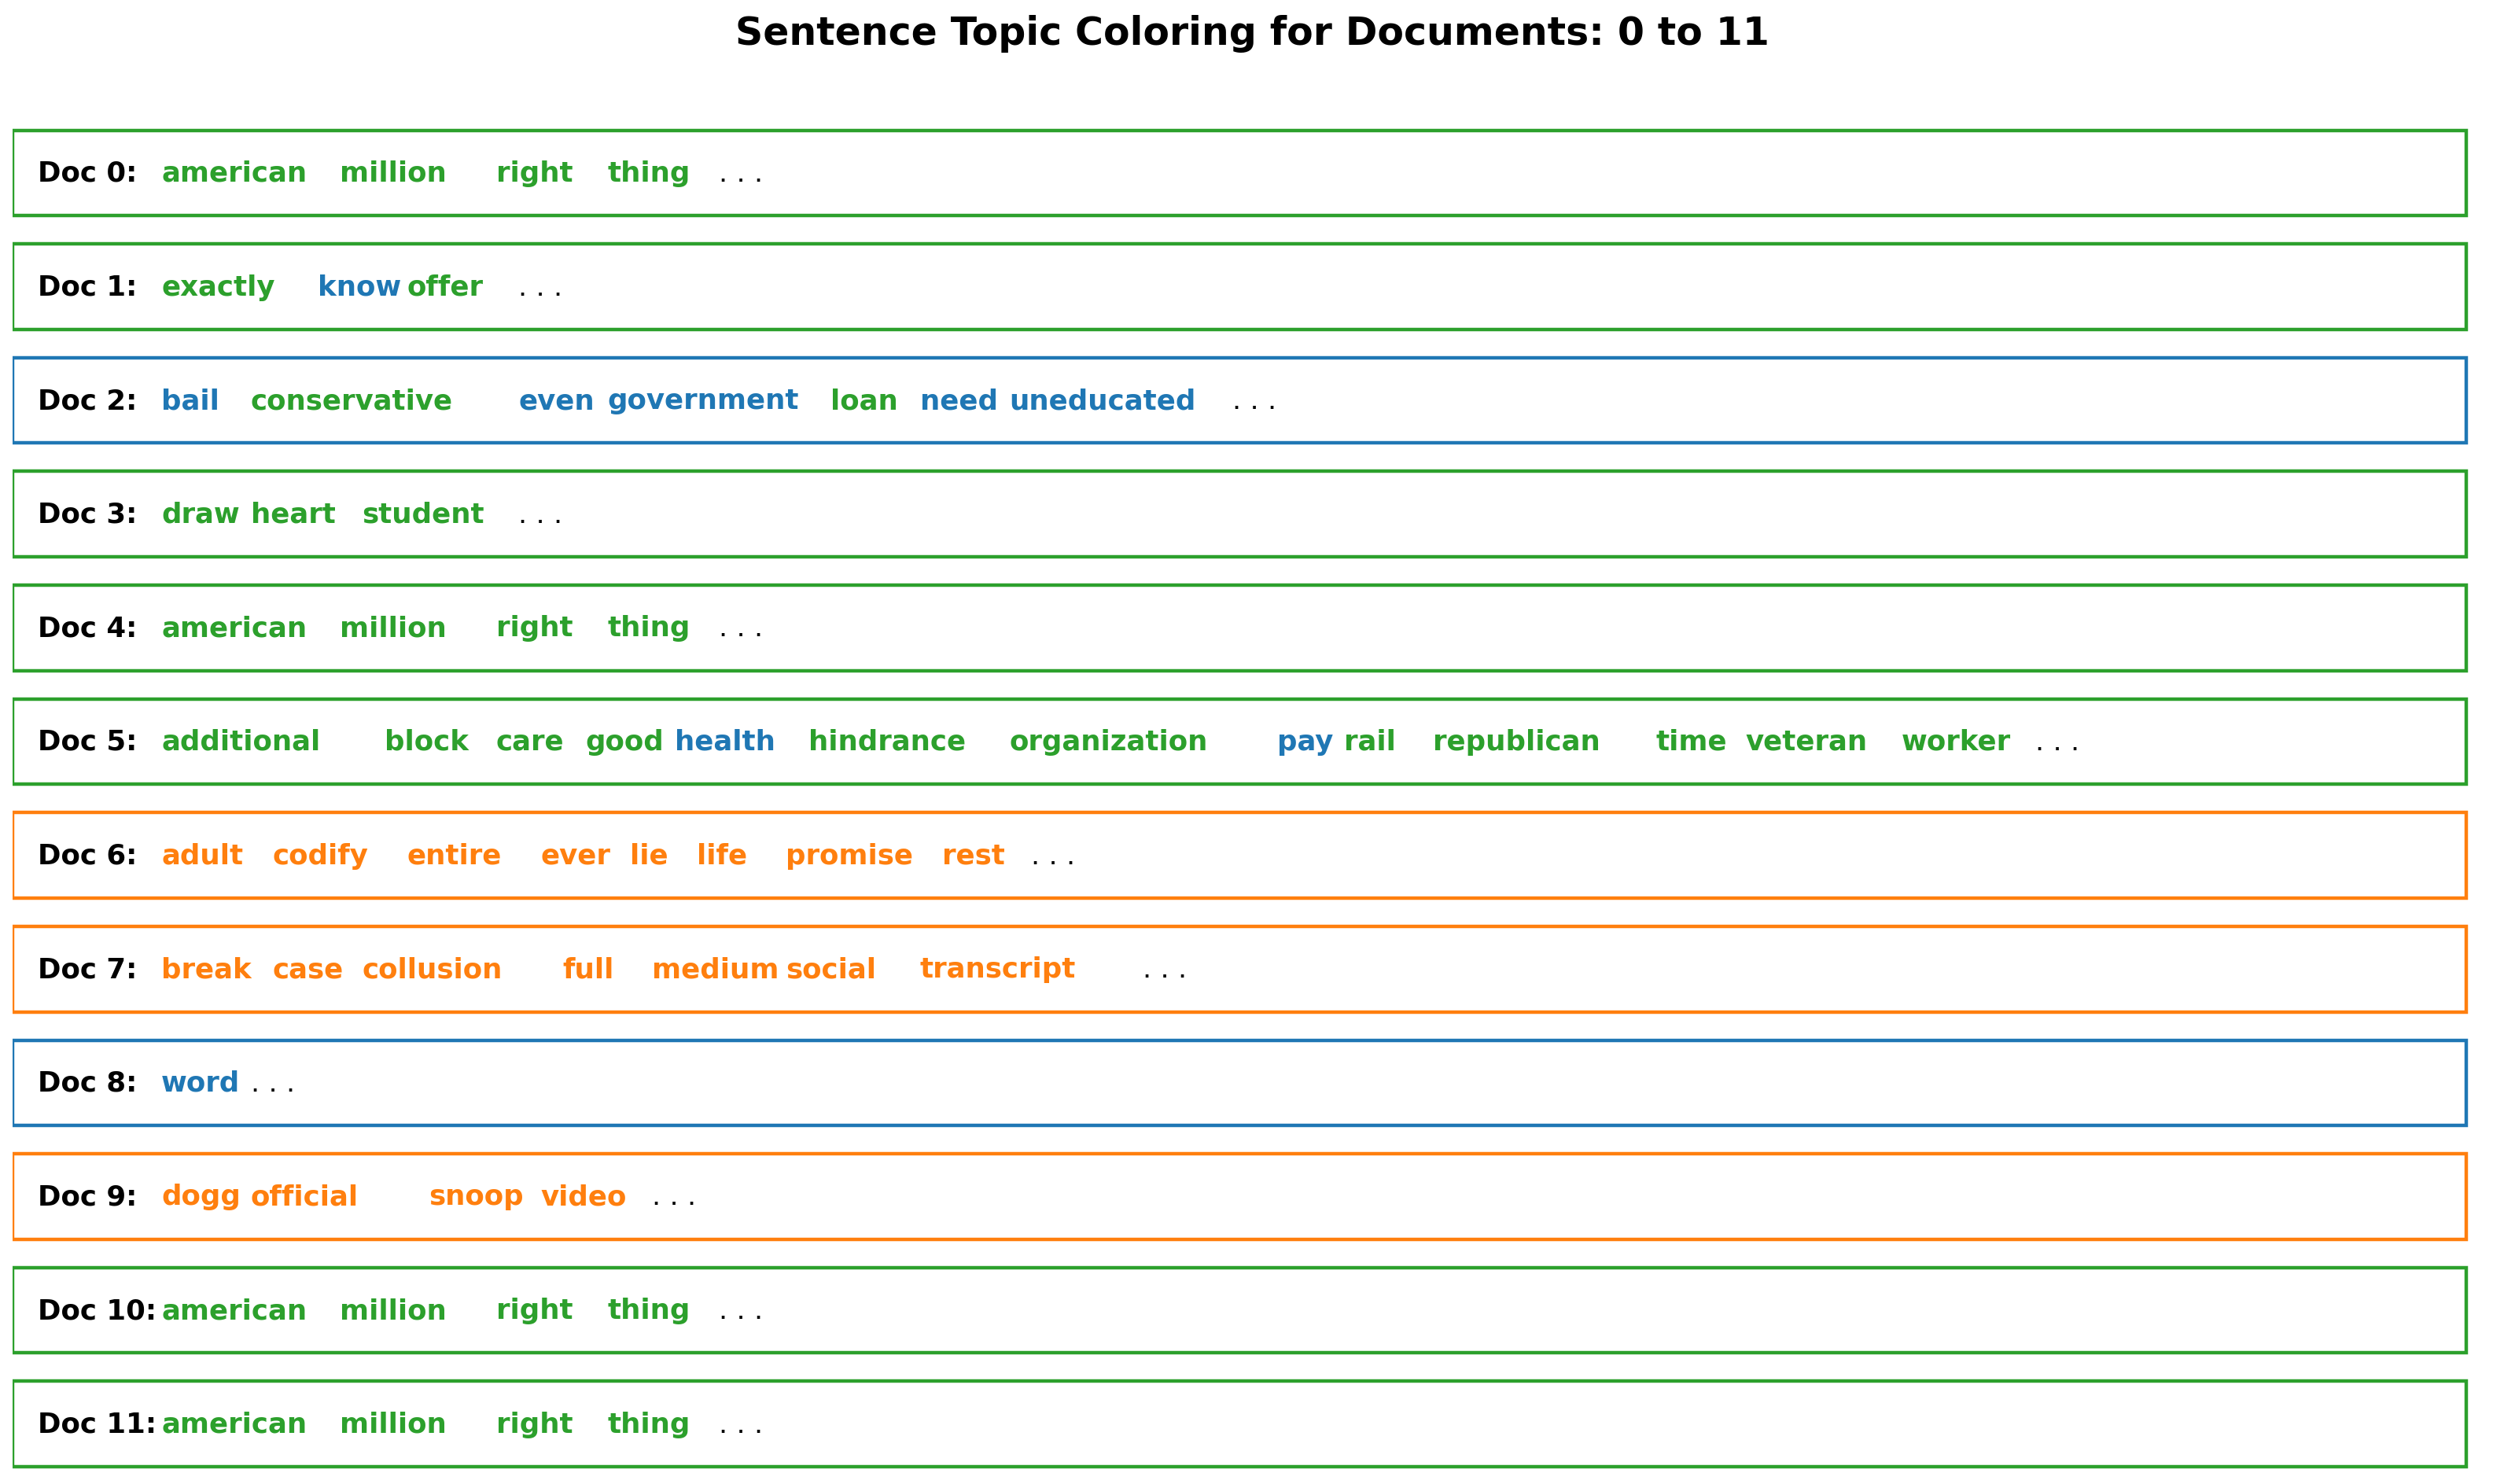

In [399]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

## What are the most discussed topics in the documents?

In [400]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

Let's make 2 plots: <br>

The number of documents for each topic by assigning the document to the topic that has the most weight in that document.<br>
The number of documents for each topic by by summing up the actual weight contribution of each topic to respective documents.<br>

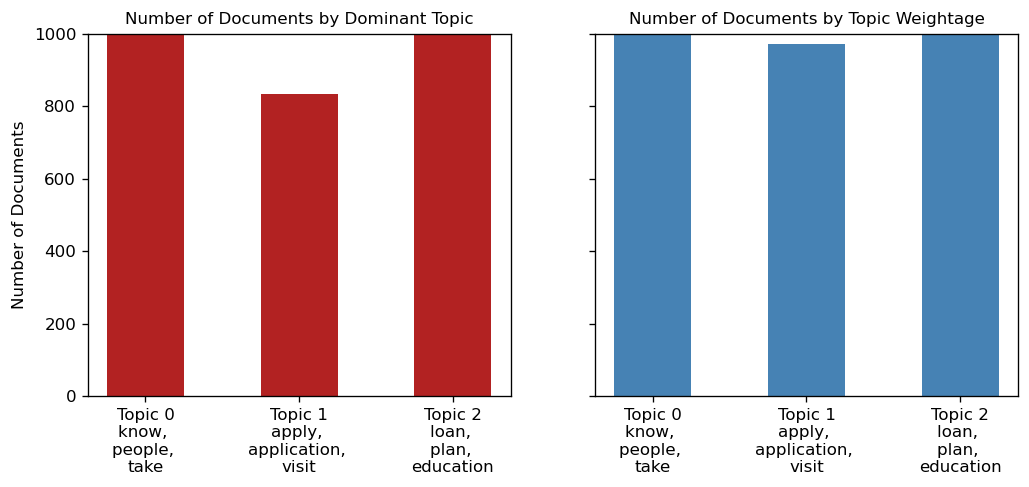

In [401]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

## t-SNE Clustering Chart

Let’s visualize the clusters of documents in a 2D space using t-SNE (t-distributed stochastic neighbor embedding) algorithm.

In [402]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 3
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

C:\Users\Arunaggiri Pandian\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Arunaggiri Pandian\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3191 samples in 0.000s...
[t-SNE] Computed neighbors for 3191 samples in 0.040s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3191
[t-SNE] Computed conditional probabilities for sample 2000 / 3191
[t-SNE] Computed conditional probabilities for sample 3000 / 3191
[t-SNE] Computed conditional probabilities for sample 3191 / 3191
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.269104
[t-SNE] KL divergence after 1000 iterations: 0.392277


Loading BokehJS ...